In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix,classification_report
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# data

In [2]:
np.random.seed(42)

In [3]:
def generate_correlated_clusters(n_samples,n_features,n_clusters,correlation=0.5,random_state=None):

    np.random.seed(random_state)

    X_blobs,y_blobs = make_blobs(n_samples=n_samples,centers=n_clusters,n_features=n_features,random_state=random_state)

    centers = np.array([X_blobs[y_blobs == i].mean(axis=0) for i in range(n_clusters)])

    X,y = [],[]

    for i,center in enumerate(centers):
    
        cov_matrix = np.full((n_features,n_features),correlation)  
        np.fill_diagonal(cov_matrix,1)  

        cluster_samples = np.random.multivariate_normal(mean=center,cov=cov_matrix,size=n_samples // n_clusters)

        X.append(cluster_samples)
        y.append(np.full(n_samples // n_clusters, i)) 

    X = np.vstack(X)
    y = np.hstack(y)

    return X, y

In [4]:
X, y = generate_correlated_clusters(n_samples=1000,n_features=2,n_clusters=2,correlation=0.1,random_state=42)
X = X + np.random.normal(scale=6,size=X.shape) 

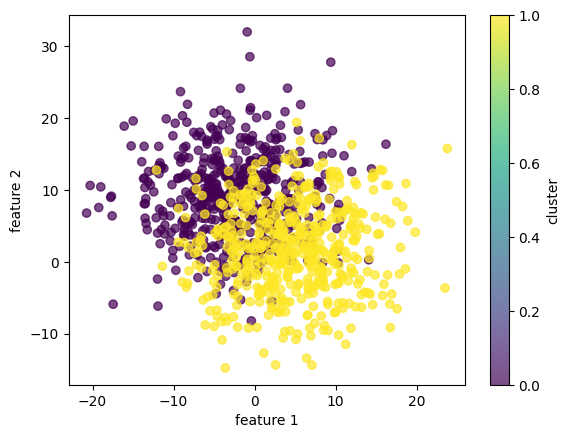

In [5]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='viridis',alpha=0.7)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.colorbar(label="cluster")
plt.show()

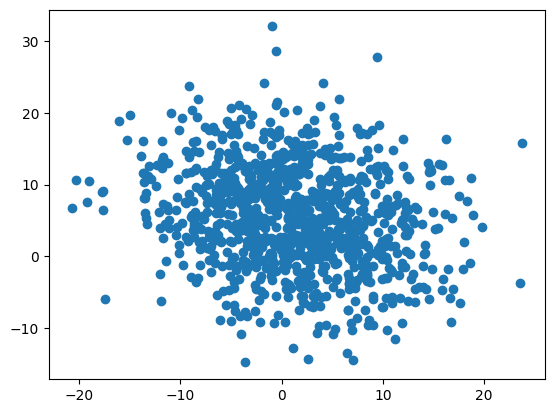

In [6]:
plt.scatter(X[:,0],X[:,1])
plt.show()

In [7]:
corr_dataset = pd.DataFrame(X) 

In [8]:
corr_dataset.columns = [f"vab_{col+1}" for col in corr_dataset.columns]

In [9]:
corr_dataset['target'] = y

In [10]:
corr_dataset

vab_1      vab_2  target
0    -6.831659   7.718899       0
1    -8.761505   7.740707       0
2   -13.535939  10.343486       0
3    -4.183721   3.488238       0
4     1.434718  15.384688       0
..         ...        ...     ...
995  -6.537895  -0.864577       1
996  -8.512996   6.150630       1
997  -8.672221   2.678594       1
998  -7.158826  -0.443087       1
999  15.177695   3.835736       1

[1000 rows x 3 columns]

In [11]:
# sns.pairplot(corr_dataset)

## correlation matrix

In [12]:
corr_dataset.iloc[:,:-1].corr()

vab_1     vab_2
vab_1  1.000000 -0.229368
vab_2 -0.229368  1.000000

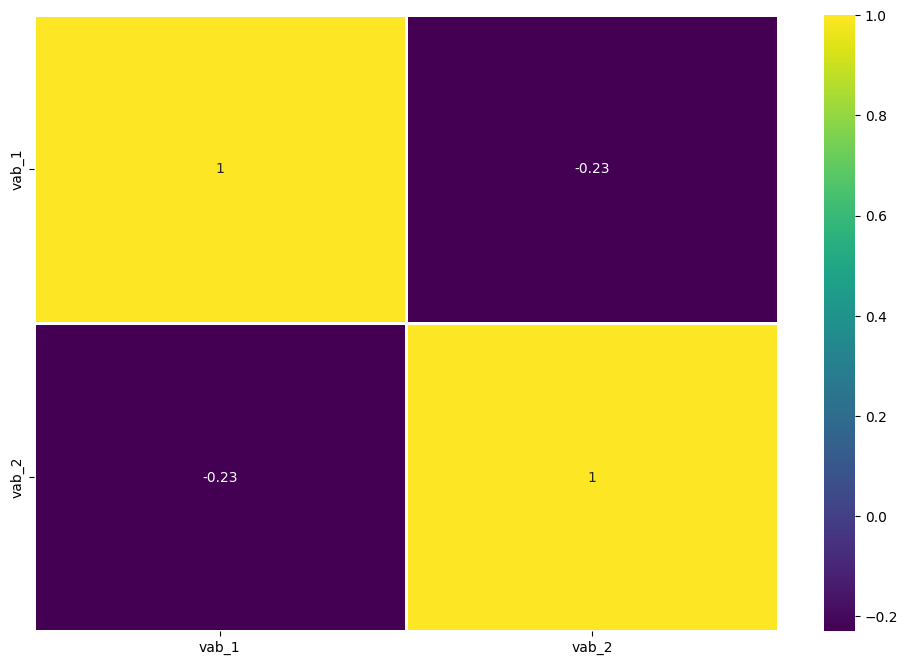

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_dataset.iloc[:,:-1].corr(),cmap='viridis',annot=True,linewidths=1)
plt.show()

## data standardization

In [14]:
X_values = corr_dataset.iloc[:,:-1].values

In [15]:
y_values = corr_dataset.iloc[:,-1].values

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()

In [18]:
X_values = scaler.fit_transform(X_values)

In [19]:
np.mean(X_values),np.std(X_values)

(-1.9451107391432743e-16, 0.9999999999999998)

In [20]:
pd.DataFrame(X_values)

0         1
0   -1.095994  0.305777
1   -1.367167  0.308852
2   -2.038047  0.675812
3   -0.723919 -0.290695
4    0.065556  1.386560
..        ...       ...
995 -1.054716 -0.904389
996 -1.332248  0.084670
997 -1.354621 -0.404845
998 -1.141966 -0.844964
999  1.996653 -0.241702

[1000 rows x 2 columns]

<Axes: ylabel='Density'>

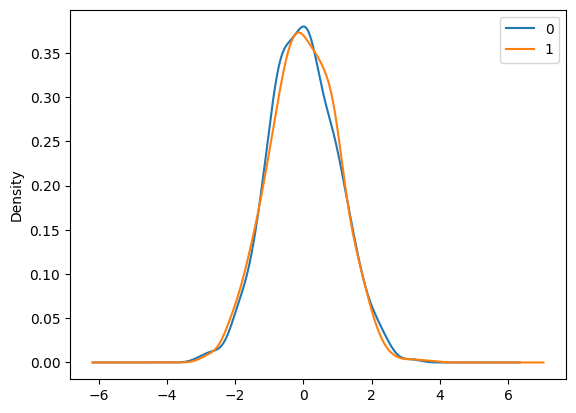

In [21]:
pd.DataFrame(X_values).plot(kind='density')

## pca 

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca_general = PCA()

In [24]:
pca_general.fit(X_values)

PCA()

In [25]:
explained_variance = pca_general.explained_variance_ratio_

In [26]:
explained_variance

array([0.61468382, 0.38531618])

In [27]:
eigenvalues = pca_general.explained_variance_

In [28]:
pd.DataFrame(eigenvalues)

0
0  1.230598
1  0.771404

In [29]:
eigenvectors = pca_general.components_

### scree plot

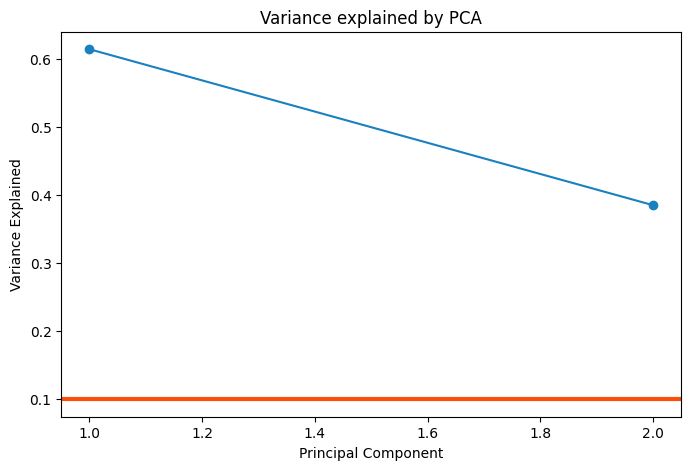

In [30]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='#1B80BF')
plt.axhline(y=0.1, color='#FC4E07', linewidth=3)
plt.title('Variance explained by PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [31]:
pca = PCA(n_components=2)

In [32]:
principal_components = pca.fit_transform(X_values)

In [33]:
pd.DataFrame(principal_components).head(8)

0         1
0  0.991202 -0.558768
1  1.185124 -0.748342
2  1.918988 -0.963246
3  0.306336 -0.717440
4  0.934091  1.026802
5  1.133772 -1.342736
6  0.334499 -1.053344
7  0.008633  0.636610

In [34]:
principal_df = pd.DataFrame(data = principal_components,columns = ['principal component 1','principal component 2'])

In [35]:
final_df = pd.concat([principal_df,corr_dataset[['target']]],axis = 1)

In [36]:
final_df

principal component 1  principal component 2  target
0                 0.991202              -0.558768       0
1                 1.185124              -0.748342       0
2                 1.918988              -0.963246       0
3                 0.306336              -0.717440       0
4                 0.934091               1.026802       0
..                     ...                    ...     ...
995               0.106297              -1.385297       1
996               1.001912              -0.882171       1
997               0.671593              -1.244130       1
998               0.210012              -1.404972       1
999              -1.582756               1.240938       1

[1000 rows x 3 columns]

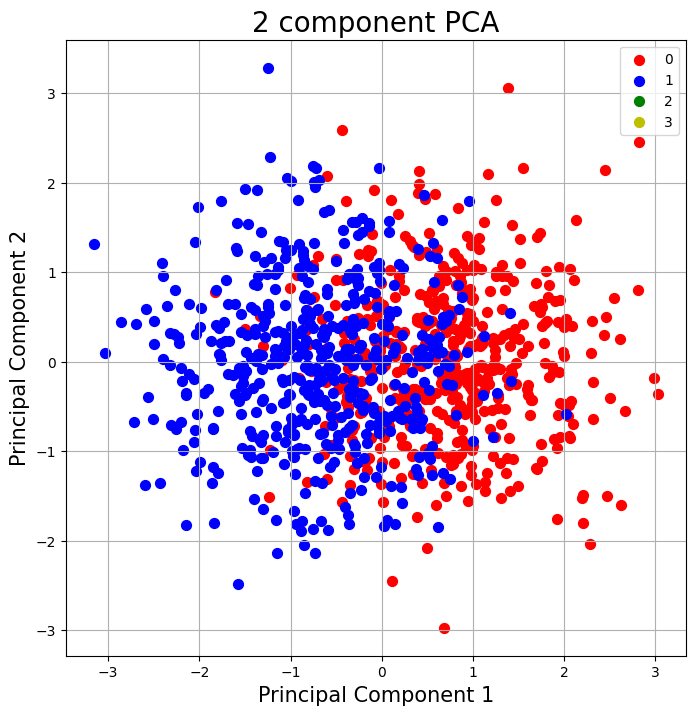

In [37]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1',fontsize = 15)
ax.set_ylabel('Principal Component 2',fontsize = 15)
ax.set_title('2 component PCA',fontsize = 20)

targets = [0,1,2,3]
colors = ['r','b','g','y']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               ,final_df.loc[indicesToKeep, 'principal component 2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

### biplot

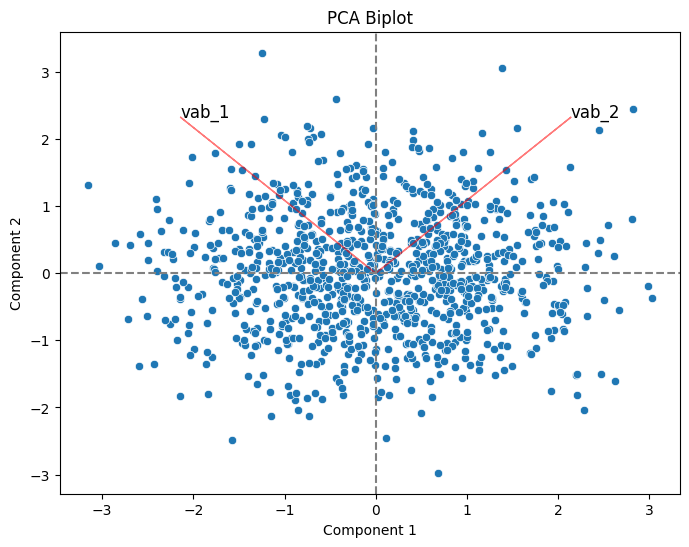

In [38]:
scores = pca.transform(X_values)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1])
for i, col in enumerate(corr_dataset.iloc[:,:-1].columns):
    plt.arrow(0, 0, eigenvectors[0, i] * max(scores[:, 0]), eigenvectors[1, i] * max(scores[:, 1]), color='r', alpha=0.5)
    plt.text(eigenvectors[0, i] * max(scores[:, 0]), eigenvectors[1, i] * max(scores[:, 1]), col, fontsize=12)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Biplot')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

### loading plot

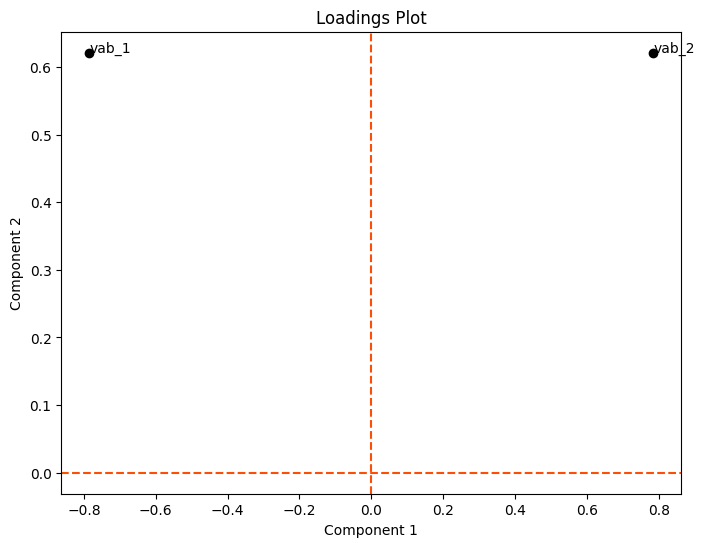

In [39]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 0], loadings[:, 1], color='black')
for i, txt in enumerate(corr_dataset.iloc[:,:-1].columns):
    plt.text(loadings[i, 0], loadings[i, 1], txt, fontsize=10)
plt.axhline(0, color='#FC4E07', linestyle='--')
plt.axvline(0, color='#FC4E07', linestyle='--')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Loadings Plot')
plt.show()

### scores

In [40]:
scores_pca = pca.transform(X_values)

In [41]:
pd.DataFrame(scores_pca).head()

0         1
0  0.991202 -0.558768
1  1.185124 -0.748342
2  1.918988 -0.963246
3  0.306336 -0.717440
4  0.934091  1.026802

## t-SNE

In [42]:
from sklearn.manifold import TSNE

In [43]:
tsne = TSNE(n_components=2,random_state=42)

In [44]:
X_tsne = tsne.fit_transform(X_values)

In [45]:
tsne_data = pd.concat([pd.DataFrame(X_tsne,columns=('dim_1','dim_2')),corr_dataset['target']],axis=1)

In [46]:
tsne_data

dim_1      dim_2  target
0    21.010347 -11.008331       0
1    23.139248 -15.479180       0
2    33.216434 -13.897078       0
3     7.094006 -17.272367       0
4    15.493345  23.264412       0
..         ...        ...     ...
995  -2.922516 -26.260843       1
996  20.128437 -17.588232       1
997  16.330326 -22.468996       1
998  -1.909281 -26.522717       1
999 -18.448753  26.906984       1

[1000 rows x 3 columns]

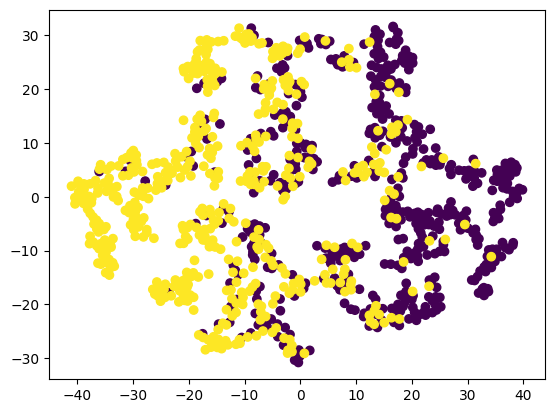

In [47]:
plt.scatter(x=tsne_data['dim_1'],y=tsne_data['dim_2'],c=tsne_data['target'])
plt.show()

In [48]:
tsne.kl_divergence_

0.4893057346343994

## UMAP

In [49]:
import umap

In [50]:
umap = umap.UMAP(random_state=42)

In [51]:
X_UMAP = umap.fit_transform(X_values)

In [52]:
UMAP_data = pd.concat([pd.DataFrame(X_UMAP,columns=('dim_1','dim_2')),corr_dataset['target']],axis=1)

In [53]:
UMAP_data

dim_1      dim_2  target
0    1.096859   3.508871       0
1    1.123976   1.876492       0
2    0.105429   0.762408       0
3    3.738891   3.073792       0
4    1.093482  10.309801       0
..        ...        ...     ...
995  4.582998   1.197661       1
996  2.011591   1.825454       1
997  2.948277   1.365449       1
998  4.400419   1.157601       1
999  9.332321  10.441537       1

[1000 rows x 3 columns]

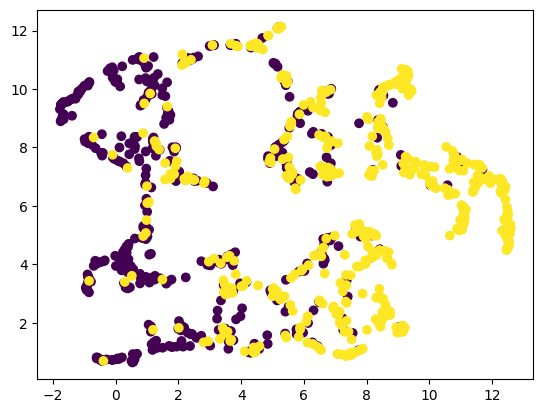

In [54]:
plt.scatter(UMAP_data['dim_1'],UMAP_data['dim_2'],c=UMAP_data['target'])
plt.show()

## k-means 

In [55]:
from sklearn.cluster import KMeans

In [56]:
kmeans = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [57]:
kmeans.fit(X_values)

KMeans(n_clusters=2, random_state=42)

In [58]:
df_kmeans = corr_dataset.copy()

In [59]:
df_kmeans['k_means'] = kmeans.labels_

In [60]:
df_kmeans

vab_1      vab_2  target  k_means
0    -6.831659   7.718899       0        0
1    -8.761505   7.740707       0        0
2   -13.535939  10.343486       0        0
3    -4.183721   3.488238       0        0
4     1.434718  15.384688       0        0
..         ...        ...     ...      ...
995  -6.537895  -0.864577       1        0
996  -8.512996   6.150630       1        0
997  -8.672221   2.678594       1        0
998  -7.158826  -0.443087       1        0
999  15.177695   3.835736       1        1

[1000 rows x 4 columns]

In [61]:
from scipy.optimize import linear_sum_assignment

y_true = df_kmeans['target'].values  
y_kmeans = df_kmeans['k_means'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_kmeans['k_means'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_kmeans['k_means'] == y_true))

accuracy before: 0.792
accuracy after: 0.792


In [62]:
df_kmeans

vab_1      vab_2  target  k_means
0    -6.831659   7.718899       0        0
1    -8.761505   7.740707       0        0
2   -13.535939  10.343486       0        0
3    -4.183721   3.488238       0        0
4     1.434718  15.384688       0        0
..         ...        ...     ...      ...
995  -6.537895  -0.864577       1        0
996  -8.512996   6.150630       1        0
997  -8.672221   2.678594       1        0
998  -7.158826  -0.443087       1        0
999  15.177695   3.835736       1        1

[1000 rows x 4 columns]

In [63]:
print(np.unique(df_kmeans['target']))

[0 1]


In [64]:
print(np.unique(kmeans.labels_))

[0 1]


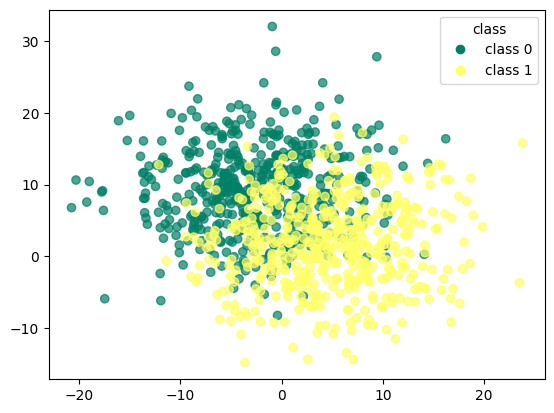

In [65]:
from matplotlib.lines import Line2D

scatter = plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], 
                      c=df_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

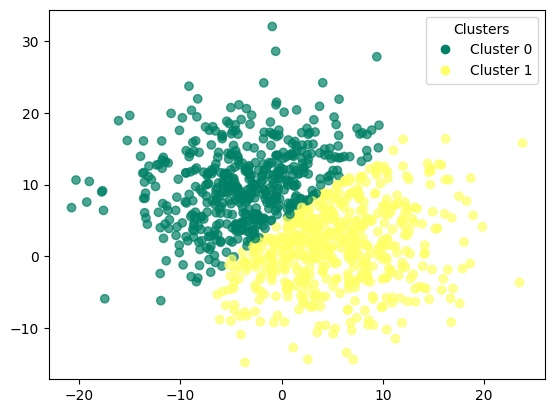

In [66]:
scatter = plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], 
                      c=df_kmeans['k_means'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_kmeans['k_means'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [67]:
kmeans.cluster_centers_

array([[-0.66997106,  0.64014609],
       [ 0.63856617, -0.61013924]])

In [68]:
print(confusion_matrix(df_kmeans['target'],df_kmeans['k_means']))

[[390 110]
 [ 98 402]]


In [69]:
print(classification_report(df_kmeans['target'],df_kmeans['k_means']))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       500
           1       0.79      0.80      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



### k-means with pca

In [70]:
kmeans_pca = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [71]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=2, random_state=42)

In [72]:
df_pca_kmeans = corr_dataset.copy()

In [73]:
df_pca_kmeans["kmeans_pca"] = kmeans_pca.labels_

In [74]:
df_pca_kmeans

vab_1      vab_2  target  kmeans_pca
0    -6.831659   7.718899       0           0
1    -8.761505   7.740707       0           0
2   -13.535939  10.343486       0           0
3    -4.183721   3.488238       0           0
4     1.434718  15.384688       0           0
..         ...        ...     ...         ...
995  -6.537895  -0.864577       1           0
996  -8.512996   6.150630       1           0
997  -8.672221   2.678594       1           0
998  -7.158826  -0.443087       1           0
999  15.177695   3.835736       1           1

[1000 rows x 4 columns]

In [75]:
y_true = df_pca_kmeans['target'].values  
y_kmeans = df_pca_kmeans['kmeans_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_kmeans['kmeans_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_kmeans['kmeans_pca'] == y_true))

accuracy before: 0.792
accuracy after: 0.792


In [76]:
df_pca_kmeans

vab_1      vab_2  target  kmeans_pca
0    -6.831659   7.718899       0           0
1    -8.761505   7.740707       0           0
2   -13.535939  10.343486       0           0
3    -4.183721   3.488238       0           0
4     1.434718  15.384688       0           0
..         ...        ...     ...         ...
995  -6.537895  -0.864577       1           0
996  -8.512996   6.150630       1           0
997  -8.672221   2.678594       1           0
998  -7.158826  -0.443087       1           0
999  15.177695   3.835736       1           1

[1000 rows x 4 columns]

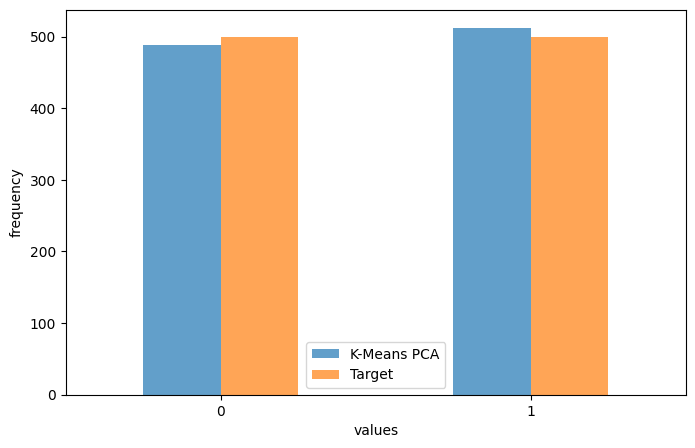

In [77]:
counts_kmeans = df_pca_kmeans['kmeans_pca'].value_counts().sort_index()
counts_target = df_pca_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means PCA': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means PCA", "Target"])
plt.xticks(rotation=0)  
plt.show()


In [78]:
print(confusion_matrix(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

[[390 110]
 [ 98 402]]


In [79]:
print(classification_report(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       500
           1       0.79      0.80      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



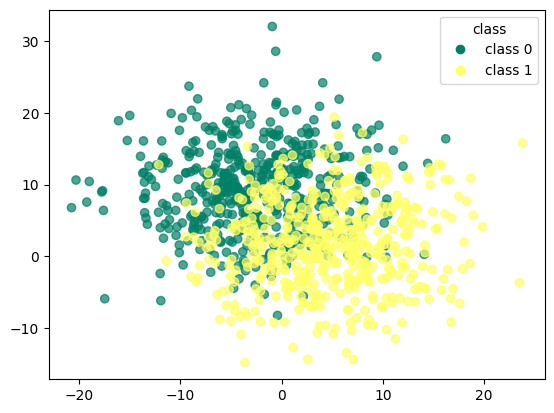

In [80]:
from matplotlib.lines import Line2D

scatter = plt.scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                      c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

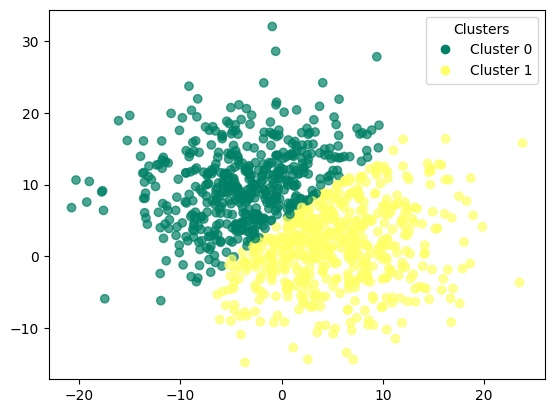

In [81]:
scatter = plt.scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                      c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

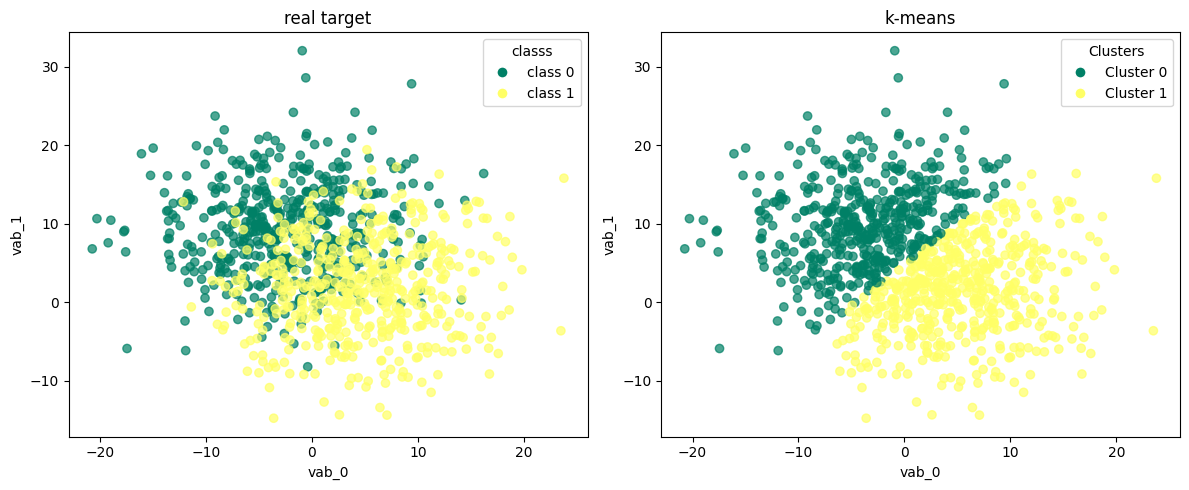

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                           c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                           c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

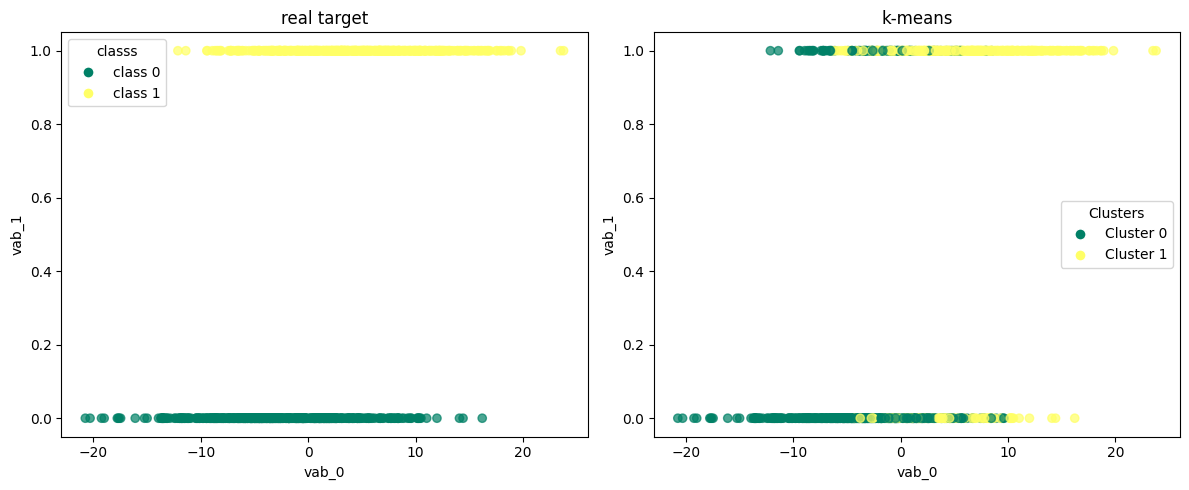

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 2], 
                           c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 2], 
                           c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

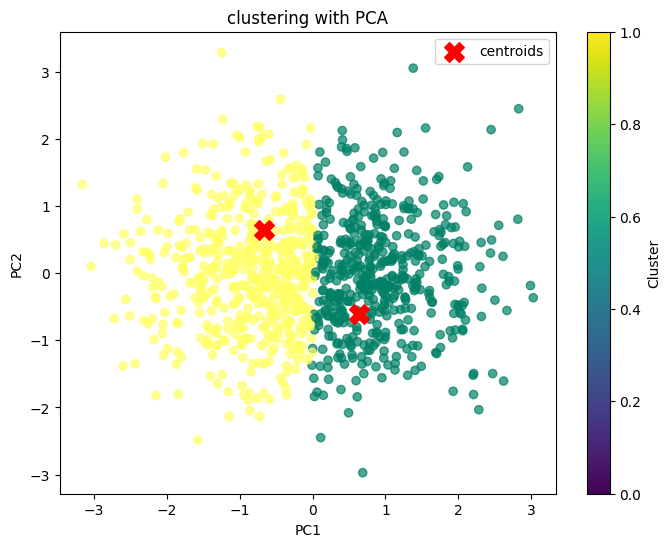

In [84]:
plt.figure(figsize=(8, 6))
plt.scatter(final_df['principal component 1'], final_df['principal component 2'] , c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=200, label='centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('clustering with PCA')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

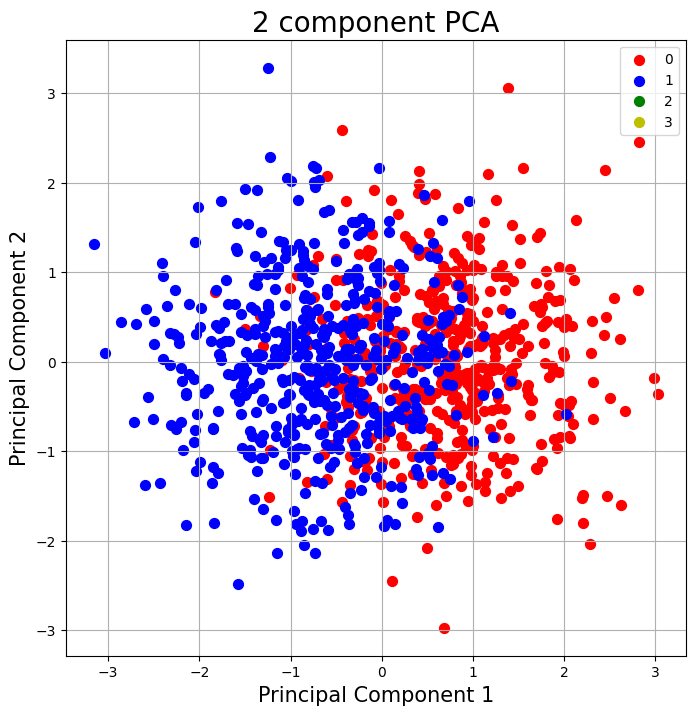

In [85]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1',fontsize = 15)
ax.set_ylabel('Principal Component 2',fontsize = 15)
ax.set_title('2 component PCA',fontsize = 20)

targets = [0,1,2,3]
colors = ['r','b','g','y']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               ,final_df.loc[indicesToKeep, 'principal component 2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

### k-means with t-SNE

In [86]:
kmeans_tsne = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [87]:
kmeans_tsne.fit(X_tsne)

KMeans(n_clusters=2, random_state=42)

In [88]:
df_tsne_kmeans = corr_dataset.copy()

In [89]:
df_tsne_kmeans['kmeans_tsne'] = kmeans_tsne.labels_

In [90]:
df_tsne_kmeans

vab_1      vab_2  target  kmeans_tsne
0    -6.831659   7.718899       0            0
1    -8.761505   7.740707       0            0
2   -13.535939  10.343486       0            0
3    -4.183721   3.488238       0            0
4     1.434718  15.384688       0            0
..         ...        ...     ...          ...
995  -6.537895  -0.864577       1            1
996  -8.512996   6.150630       1            0
997  -8.672221   2.678594       1            0
998  -7.158826  -0.443087       1            1
999  15.177695   3.835736       1            1

[1000 rows x 4 columns]

In [91]:
y_true = df_tsne_kmeans['target'].values  
y_kmeans = df_tsne_kmeans['kmeans_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_kmeans['kmeans_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_kmeans['kmeans_tsne'] == y_true))

accuracy before: 0.789
accuracy after: 0.789


In [92]:
df_tsne_kmeans

vab_1      vab_2  target  kmeans_tsne
0    -6.831659   7.718899       0            0
1    -8.761505   7.740707       0            0
2   -13.535939  10.343486       0            0
3    -4.183721   3.488238       0            0
4     1.434718  15.384688       0            0
..         ...        ...     ...          ...
995  -6.537895  -0.864577       1            1
996  -8.512996   6.150630       1            0
997  -8.672221   2.678594       1            0
998  -7.158826  -0.443087       1            1
999  15.177695   3.835736       1            1

[1000 rows x 4 columns]

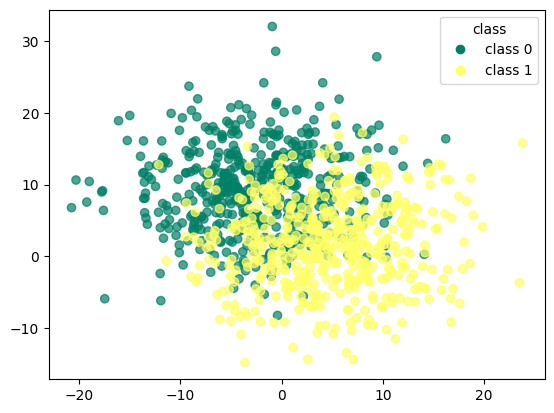

In [93]:
from matplotlib.lines import Line2D

scatter = plt.scatter(df_tsne_kmeans.iloc[:, 0], df_tsne_kmeans.iloc[:, 1], 
                      c=df_tsne_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

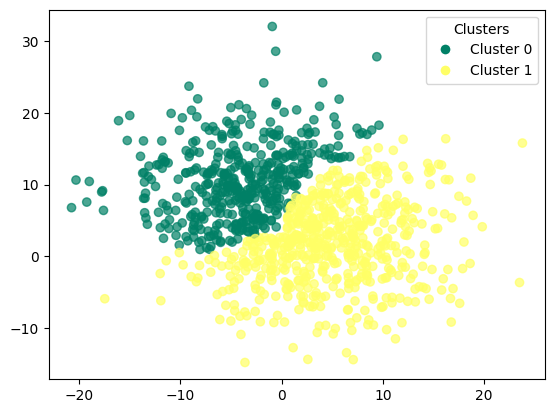

In [94]:
scatter = plt.scatter(df_tsne_kmeans.iloc[:, 0], df_tsne_kmeans.iloc[:, 1], 
                      c=df_tsne_kmeans['kmeans_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_kmeans['kmeans_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

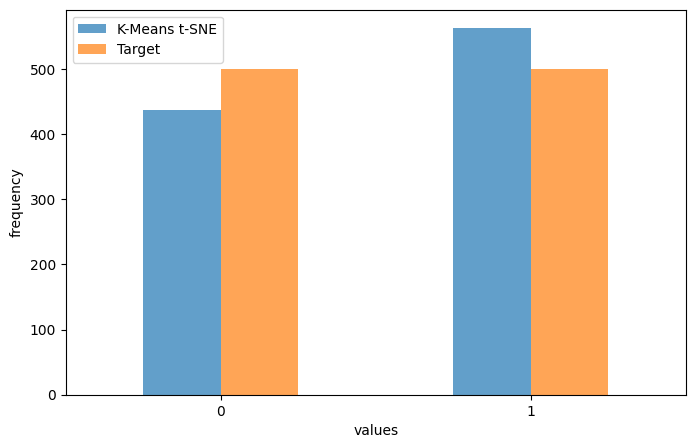

In [95]:
counts_kmeans = df_tsne_kmeans['kmeans_tsne'].value_counts().sort_index()
counts_target = df_tsne_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means t-SNE': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means t-SNE", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [96]:
print(confusion_matrix(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne']))

[[363 137]
 [ 74 426]]


In [97]:
print(classification_report(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.83      0.73      0.77       500
           1       0.76      0.85      0.80       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



### k-means with UMAP

In [98]:
kmeans_UMAP = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [99]:
kmeans_UMAP.fit(X_UMAP)

KMeans(n_clusters=2, random_state=42)

In [100]:
df_UMAP_kmeans = corr_dataset.copy()

In [101]:
df_UMAP_kmeans['kmeans_UMAP'] = kmeans_UMAP.labels_

In [102]:
df_UMAP_kmeans

vab_1      vab_2  target  kmeans_UMAP
0    -6.831659   7.718899       0            0
1    -8.761505   7.740707       0            0
2   -13.535939  10.343486       0            0
3    -4.183721   3.488238       0            0
4     1.434718  15.384688       0            0
..         ...        ...     ...          ...
995  -6.537895  -0.864577       1            0
996  -8.512996   6.150630       1            0
997  -8.672221   2.678594       1            0
998  -7.158826  -0.443087       1            0
999  15.177695   3.835736       1            1

[1000 rows x 4 columns]

In [103]:
y_true = df_UMAP_kmeans['target'].values  
y_kmeans = df_UMAP_kmeans['kmeans_UMAP'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_UMAP_kmeans['kmeans_UMAP'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_UMAP_kmeans['kmeans_UMAP'] == y_true))

accuracy before: 0.786
accuracy after: 0.786


In [104]:
df_UMAP_kmeans

vab_1      vab_2  target  kmeans_UMAP
0    -6.831659   7.718899       0            0
1    -8.761505   7.740707       0            0
2   -13.535939  10.343486       0            0
3    -4.183721   3.488238       0            0
4     1.434718  15.384688       0            0
..         ...        ...     ...          ...
995  -6.537895  -0.864577       1            0
996  -8.512996   6.150630       1            0
997  -8.672221   2.678594       1            0
998  -7.158826  -0.443087       1            0
999  15.177695   3.835736       1            1

[1000 rows x 4 columns]

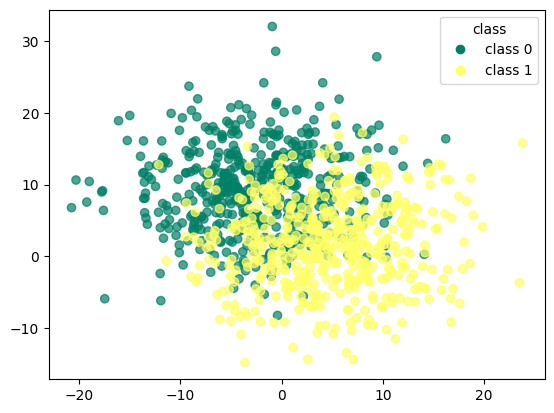

In [105]:
from matplotlib.lines import Line2D

scatter = plt.scatter(df_UMAP_kmeans.iloc[:, 0], df_UMAP_kmeans.iloc[:, 1], 
                      c=df_UMAP_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_UMAP_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

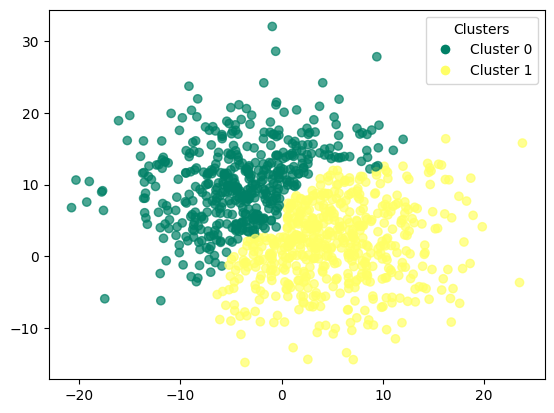

In [106]:
scatter = plt.scatter(df_UMAP_kmeans.iloc[:, 0], df_UMAP_kmeans.iloc[:, 1], 
                      c=df_UMAP_kmeans['kmeans_UMAP'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_UMAP_kmeans['kmeans_UMAP'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

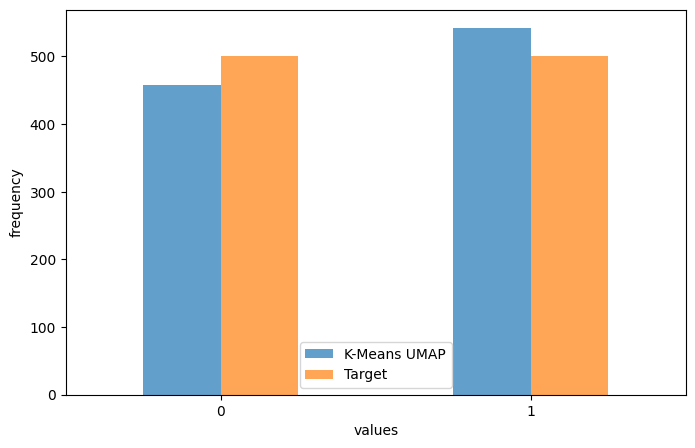

In [107]:
counts_kmeans = df_UMAP_kmeans['kmeans_UMAP'].value_counts().sort_index()
counts_target = df_UMAP_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means UMAP': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means UMAP", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [108]:
print(confusion_matrix(df_UMAP_kmeans['target'],df_UMAP_kmeans['kmeans_UMAP']))

[[372 128]
 [ 86 414]]


In [109]:
print(classification_report(df_UMAP_kmeans['target'],df_UMAP_kmeans['kmeans_UMAP'])) 

              precision    recall  f1-score   support

           0       0.81      0.74      0.78       500
           1       0.76      0.83      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



## t-clustering

In [110]:
def trimmed_clustering(X,n_clusters,trim_fraction=0.1):

    kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(X)
    distances = np.min(kmeans.transform(X),axis=1)
    
    trim_threshold = np.percentile(distances,100 * (1 - trim_fraction))
    trimmed_X = X[distances < trim_threshold]
    trimmed_indices = np.where(distances < trim_threshold)[0]
    trimmed_kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(trimmed_X)
    
    return trimmed_kmeans,trimmed_indices

In [111]:
trimmed_kmeans,trimmmed_indces = trimmed_clustering(X_values,n_clusters=2,trim_fraction=0.1)

In [112]:
trimmed_kmeans

KMeans(n_clusters=2, random_state=42)

In [113]:
df_t_clust = corr_dataset.copy()

In [114]:
df_t_clust = df_t_clust.iloc[trimmmed_indces]  

In [115]:
df_t_clust['t_clust'] = trimmed_kmeans.labels_

In [116]:
df_t_clust

vab_1      vab_2  target  t_clust
0    -6.831659   7.718899       0        0
1    -8.761505   7.740707       0        0
2   -13.535939  10.343486       0        0
3    -4.183721   3.488238       0        0
4     1.434718  15.384688       0        0
..         ...        ...     ...      ...
995  -6.537895  -0.864577       1        0
996  -8.512996   6.150630       1        0
997  -8.672221   2.678594       1        0
998  -7.158826  -0.443087       1        0
999  15.177695   3.835736       1        1

[900 rows x 4 columns]

In [117]:
from scipy.optimize import linear_sum_assignment

y_true = df_t_clust['target'].values  
y_kmeans = df_t_clust['t_clust'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_t_clust['t_clust'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_t_clust['t_clust'] == y_true))

accuracy before: 0.7811111111111111
accuracy after: 0.7811111111111111


In [118]:
df_t_clust

vab_1      vab_2  target  t_clust
0    -6.831659   7.718899       0        0
1    -8.761505   7.740707       0        0
2   -13.535939  10.343486       0        0
3    -4.183721   3.488238       0        0
4     1.434718  15.384688       0        0
..         ...        ...     ...      ...
995  -6.537895  -0.864577       1        0
996  -8.512996   6.150630       1        0
997  -8.672221   2.678594       1        0
998  -7.158826  -0.443087       1        0
999  15.177695   3.835736       1        1

[900 rows x 4 columns]

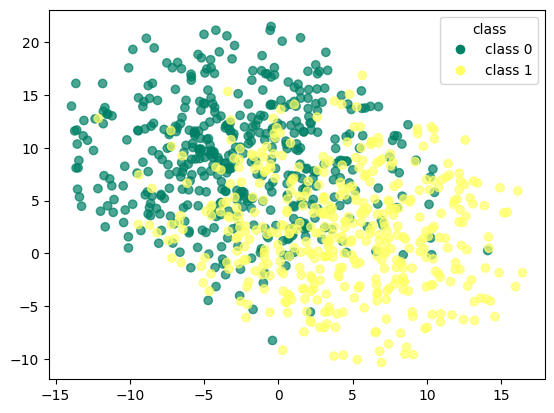

In [119]:
from matplotlib.lines import Line2D

scatter = plt.scatter(df_t_clust.iloc[:, 0], df_t_clust.iloc[:, 1], 
                      c=df_t_clust['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_t_clust['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

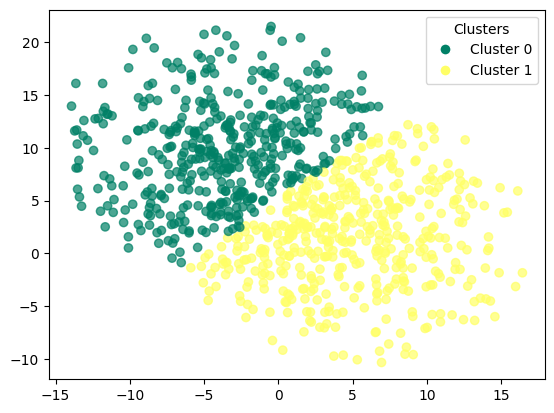

In [120]:
scatter = plt.scatter(df_t_clust.iloc[:, 0], df_t_clust.iloc[:, 1], 
                      c=df_t_clust['t_clust'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_t_clust['t_clust'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [121]:
print(confusion_matrix(df_t_clust['target'],df_t_clust['t_clust']))

[[353 110]
 [ 87 350]]


In [122]:
print(classification_report(df_t_clust['target'],df_t_clust['t_clust']))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       463
           1       0.76      0.80      0.78       437

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900



### t-clustering with pca

In [123]:
t_clust_pca,trimmmed_indices = trimmed_clustering(scores_pca,n_clusters=2,trim_fraction=0.1)

In [124]:
t_clust_pca

KMeans(n_clusters=2, random_state=42)

In [125]:
df_pca_t_clust = corr_dataset.copy()

In [126]:
df_pca_t_clust = df_pca_t_clust.iloc[trimmmed_indces]  

In [127]:
df_pca_t_clust["t_clust_pca"] = t_clust_pca.labels_

In [128]:
df_pca_t_clust

vab_1      vab_2  target  t_clust_pca
0    -6.831659   7.718899       0            0
1    -8.761505   7.740707       0            0
2   -13.535939  10.343486       0            0
3    -4.183721   3.488238       0            0
4     1.434718  15.384688       0            0
..         ...        ...     ...          ...
995  -6.537895  -0.864577       1            0
996  -8.512996   6.150630       1            0
997  -8.672221   2.678594       1            0
998  -7.158826  -0.443087       1            0
999  15.177695   3.835736       1            1

[900 rows x 4 columns]

In [129]:
y_true = df_pca_t_clust['target'].values  
y_kmeans = df_pca_t_clust['t_clust_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_t_clust['t_clust_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_t_clust['t_clust_pca'] == y_true))

accuracy before: 0.7811111111111111
accuracy after: 0.7811111111111111


In [130]:
df_pca_t_clust

vab_1      vab_2  target  t_clust_pca
0    -6.831659   7.718899       0            0
1    -8.761505   7.740707       0            0
2   -13.535939  10.343486       0            0
3    -4.183721   3.488238       0            0
4     1.434718  15.384688       0            0
..         ...        ...     ...          ...
995  -6.537895  -0.864577       1            0
996  -8.512996   6.150630       1            0
997  -8.672221   2.678594       1            0
998  -7.158826  -0.443087       1            0
999  15.177695   3.835736       1            1

[900 rows x 4 columns]

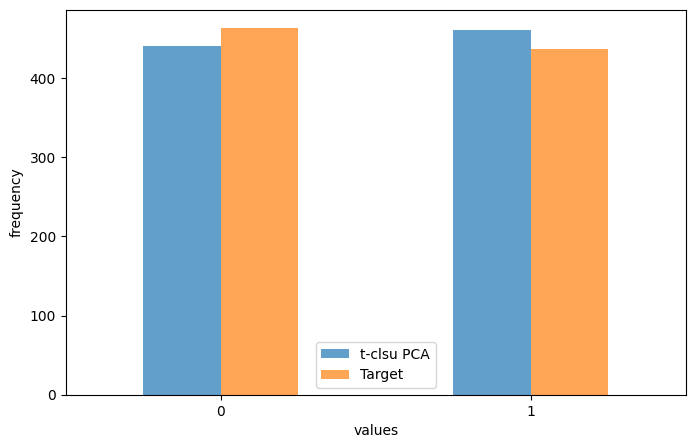

In [131]:
counts_kmeans = df_pca_t_clust['t_clust_pca'].value_counts().sort_index()
counts_target = df_pca_t_clust['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'t-clust PCA': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["t-clsu PCA", "Target"])
plt.xticks(rotation=0)  
plt.show()


In [132]:
print(confusion_matrix(df_pca_t_clust['target'],df_pca_t_clust['t_clust_pca']))

[[353 110]
 [ 87 350]]


In [133]:
print(classification_report(df_pca_t_clust['target'],df_pca_t_clust['t_clust_pca']))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       463
           1       0.76      0.80      0.78       437

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900



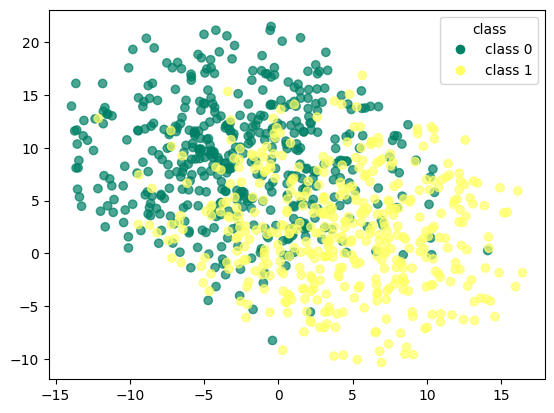

In [134]:
from matplotlib.lines import Line2D

scatter = plt.scatter(df_pca_t_clust.iloc[:, 0], df_pca_t_clust.iloc[:, 1], 
                      c=df_pca_t_clust['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_t_clust['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

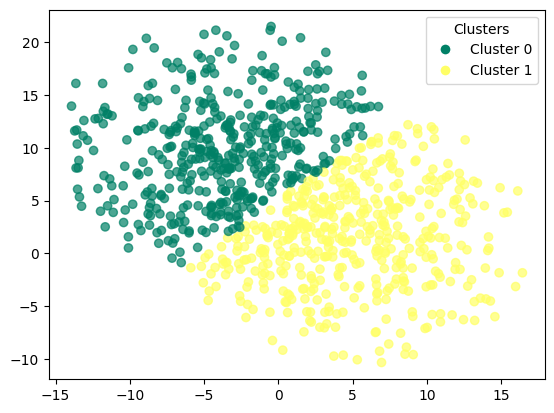

In [135]:
scatter = plt.scatter(df_pca_t_clust.iloc[:, 0], df_pca_t_clust.iloc[:, 1], 
                      c=df_pca_t_clust['t_clust_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_t_clust['t_clust_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

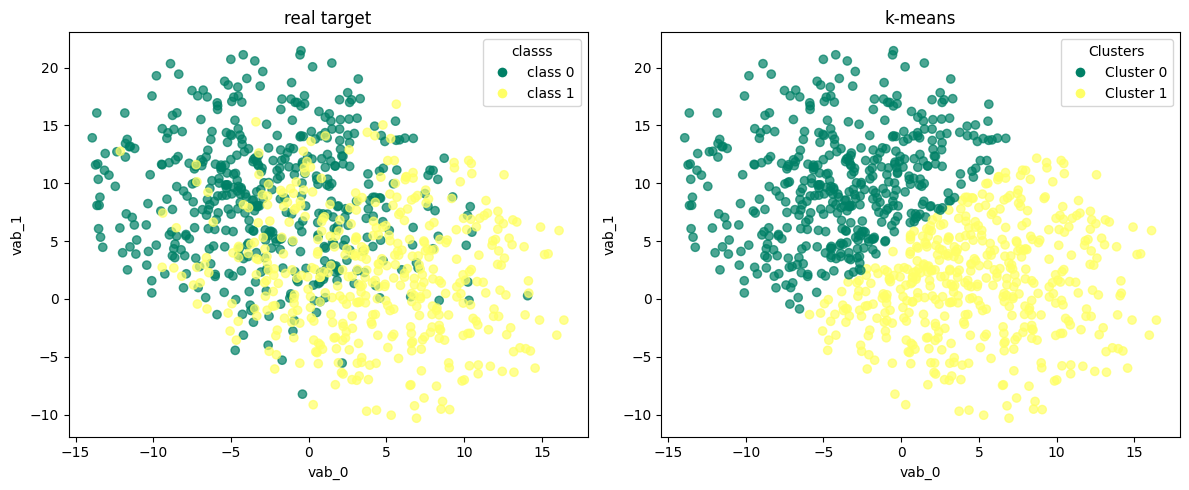

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_t_clust.iloc[:, 0], df_pca_t_clust.iloc[:, 1], 
                           c=df_pca_t_clust['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_t_clust['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_t_clust.iloc[:, 0], df_pca_t_clust.iloc[:, 1], 
                           c=df_pca_t_clust['t_clust_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_t_clust['t_clust_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

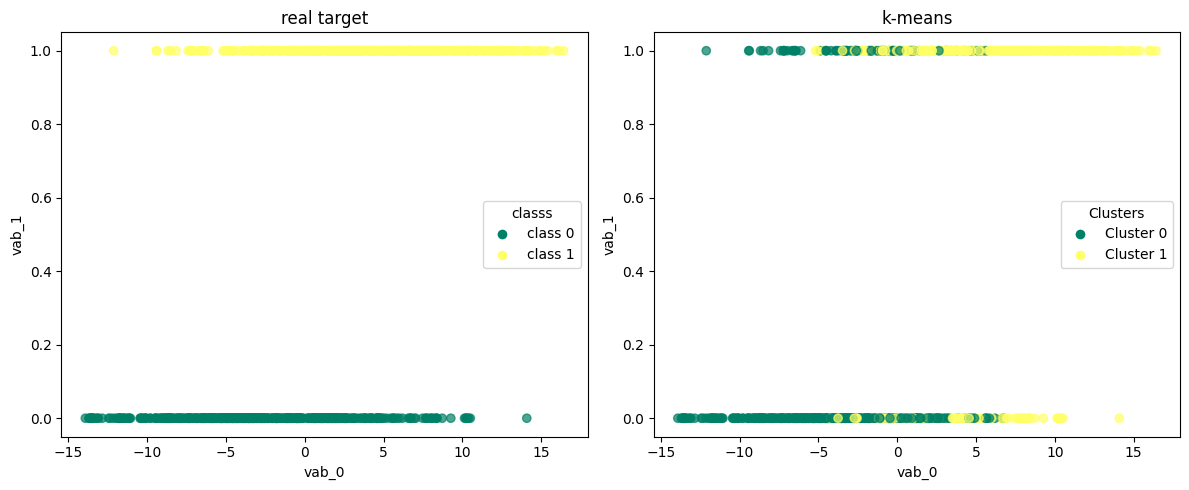

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_t_clust.iloc[:, 0], df_pca_t_clust.iloc[:, 2], 
                           c=df_pca_t_clust['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_t_clust['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_t_clust.iloc[:, 0], df_pca_t_clust.iloc[:, 2], 
                           c=df_pca_t_clust['t_clust_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_t_clust['t_clust_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

### t-clustering with t-SNE

In [138]:
t_clust_tsne,trimmmed_indices = trimmed_clustering(X_tsne,n_clusters=2,trim_fraction=0.1)

In [139]:
t_clust_tsne

KMeans(n_clusters=2, random_state=42)

In [140]:
df_tsne_t_clust = corr_dataset.copy()

In [141]:
df_tsne_t_clust = df_tsne_t_clust.iloc[trimmmed_indces]  

In [142]:
df_tsne_t_clust['t_clust_tsne'] = t_clust_tsne.labels_

In [143]:
df_tsne_t_clust

vab_1      vab_2  target  t_clust_tsne
0    -6.831659   7.718899       0             0
1    -8.761505   7.740707       0             0
2   -13.535939  10.343486       0             0
3    -4.183721   3.488238       0             0
4     1.434718  15.384688       0             0
..         ...        ...     ...           ...
995  -6.537895  -0.864577       1             1
996  -8.512996   6.150630       1             1
997  -8.672221   2.678594       1             1
998  -7.158826  -0.443087       1             0
999  15.177695   3.835736       1             0

[900 rows x 4 columns]

In [144]:
y_true = df_tsne_t_clust['target'].values  
y_kmeans = df_tsne_t_clust['t_clust_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_t_clust['t_clust_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_t_clust['t_clust_tsne'] == y_true))

accuracy before: 0.7866666666666666
accuracy after: 0.7866666666666666


In [145]:
df_tsne_t_clust

vab_1      vab_2  target  t_clust_tsne
0    -6.831659   7.718899       0             0
1    -8.761505   7.740707       0             0
2   -13.535939  10.343486       0             0
3    -4.183721   3.488238       0             0
4     1.434718  15.384688       0             0
..         ...        ...     ...           ...
995  -6.537895  -0.864577       1             1
996  -8.512996   6.150630       1             1
997  -8.672221   2.678594       1             1
998  -7.158826  -0.443087       1             0
999  15.177695   3.835736       1             0

[900 rows x 4 columns]

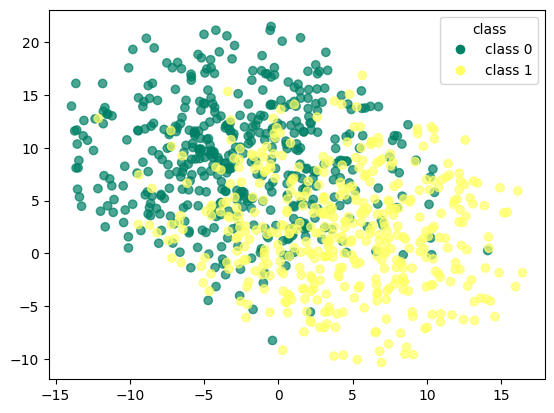

In [146]:
from matplotlib.lines import Line2D

scatter = plt.scatter(df_tsne_t_clust.iloc[:, 0], df_tsne_t_clust.iloc[:, 1], 
                      c=df_tsne_t_clust['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_t_clust['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

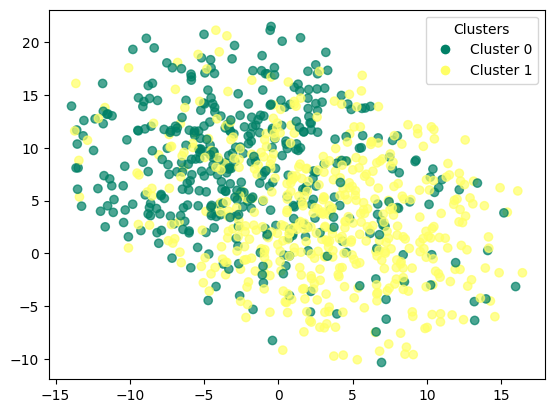

In [147]:
scatter = plt.scatter(df_tsne_t_clust.iloc[:, 0], df_tsne_t_clust.iloc[:, 1], 
                      c=df_tsne_t_clust['t_clust_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_t_clust['t_clust_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

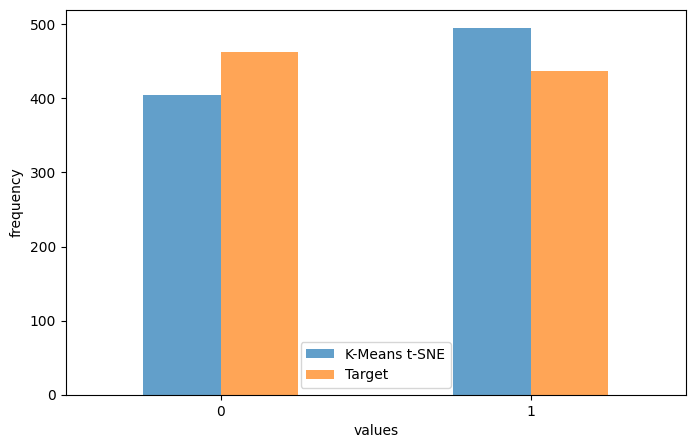

In [148]:
counts_kmeans = df_tsne_t_clust['t_clust_tsne'].value_counts().sort_index()
counts_target = df_tsne_t_clust['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means t-SNE': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means t-SNE", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [149]:
print(confusion_matrix(df_tsne_t_clust['target'],df_tsne_t_clust['t_clust_tsne']))

[[338 125]
 [ 67 370]]


In [150]:
print(classification_report(df_tsne_t_clust['target'],df_tsne_t_clust['t_clust_tsne'])) 

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       463
           1       0.75      0.85      0.79       437

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.79       900
weighted avg       0.79      0.79      0.79       900



### t-clustering with UMAP

In [151]:
t_clust_UMAP,trimmmed_indices = trimmed_clustering(X_UMAP,n_clusters=2,trim_fraction=0.1)

In [152]:
t_clust_UMAP

KMeans(n_clusters=2, random_state=42)

In [153]:
df_UMAP_t_clust = corr_dataset.copy()

In [154]:
df_UMAP_t_clust = df_UMAP_t_clust.iloc[trimmmed_indices]

In [155]:
df_UMAP_t_clust['t_clust_UMAP'] = t_clust_UMAP.labels_

In [156]:
df_UMAP_t_clust

vab_1      vab_2  target  t_clust_UMAP
0    -6.831659   7.718899       0             0
1    -8.761505   7.740707       0             0
2   -13.535939  10.343486       0             0
3    -4.183721   3.488238       0             0
4     1.434718  15.384688       0             0
..         ...        ...     ...           ...
993   7.131683  -1.430074       1             1
994  16.423465  -1.831601       1             1
996  -8.512996   6.150630       1             0
997  -8.672221   2.678594       1             0
999  15.177695   3.835736       1             1

[900 rows x 4 columns]

In [157]:
y_true = df_UMAP_t_clust['target'].values  
y_kmeans = df_UMAP_t_clust['t_clust_UMAP'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_UMAP_t_clust['t_clust_UMAP'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_UMAP_t_clust['t_clust_UMAP'] == y_true))

accuracy before: 0.79
accuracy after: 0.79


In [158]:
df_UMAP_t_clust

vab_1      vab_2  target  t_clust_UMAP
0    -6.831659   7.718899       0             0
1    -8.761505   7.740707       0             0
2   -13.535939  10.343486       0             0
3    -4.183721   3.488238       0             0
4     1.434718  15.384688       0             0
..         ...        ...     ...           ...
993   7.131683  -1.430074       1             1
994  16.423465  -1.831601       1             1
996  -8.512996   6.150630       1             0
997  -8.672221   2.678594       1             0
999  15.177695   3.835736       1             1

[900 rows x 4 columns]

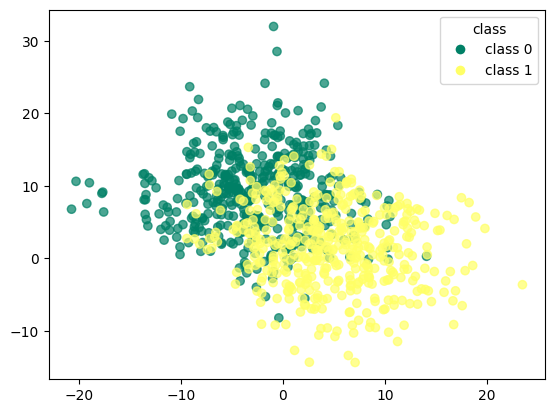

In [159]:
from matplotlib.lines import Line2D

scatter = plt.scatter(df_UMAP_t_clust.iloc[:, 0], df_UMAP_t_clust.iloc[:, 1], 
                      c=df_UMAP_t_clust['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_UMAP_t_clust['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

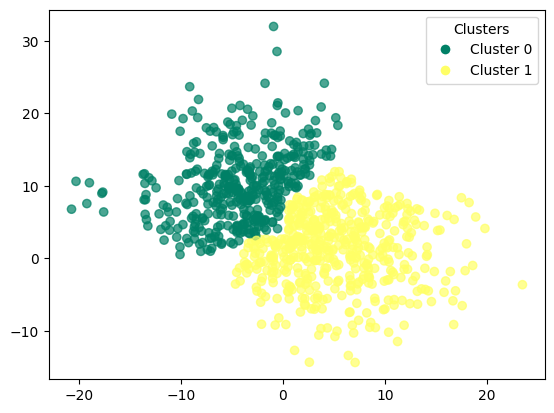

In [160]:
scatter = plt.scatter(df_UMAP_t_clust.iloc[:, 0], df_UMAP_t_clust.iloc[:, 1], 
                      c=df_UMAP_t_clust['t_clust_UMAP'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_UMAP_t_clust['t_clust_UMAP'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

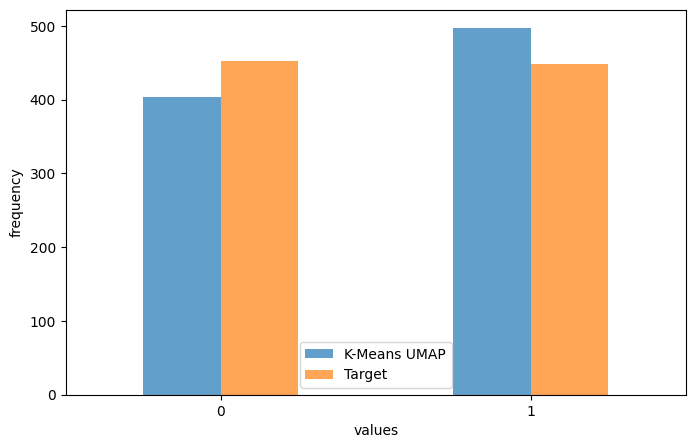

In [161]:
counts_kmeans = df_UMAP_t_clust['t_clust_UMAP'].value_counts().sort_index()
counts_target = df_UMAP_t_clust['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means UMAP': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means UMAP", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [162]:
print(confusion_matrix(df_UMAP_t_clust['target'],df_UMAP_t_clust['t_clust_UMAP']))

[[333 119]
 [ 70 378]]


In [163]:
print(classification_report(df_UMAP_t_clust['target'],df_UMAP_t_clust['t_clust_UMAP'])) 

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       452
           1       0.76      0.84      0.80       448

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.79       900
weighted avg       0.79      0.79      0.79       900



# overall results k-means

In [164]:
print(classification_report(df_kmeans['target'],df_kmeans['k_means']))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       500
           1       0.79      0.80      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



In [165]:
print(classification_report(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       500
           1       0.79      0.80      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



In [166]:
print(classification_report(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.83      0.73      0.77       500
           1       0.76      0.85      0.80       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



In [167]:
print(classification_report(df_UMAP_kmeans['target'],df_UMAP_kmeans['kmeans_UMAP'])) 

              precision    recall  f1-score   support

           0       0.81      0.74      0.78       500
           1       0.76      0.83      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



# overall results t-clustering

In [168]:
print(classification_report(df_t_clust['target'],df_t_clust['t_clust']))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       463
           1       0.76      0.80      0.78       437

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900



In [169]:
print(classification_report(df_pca_t_clust['target'],df_pca_t_clust['t_clust_pca']))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       463
           1       0.76      0.80      0.78       437

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900



In [170]:
print(classification_report(df_tsne_t_clust['target'],df_tsne_t_clust['t_clust_tsne'])) 

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       463
           1       0.75      0.85      0.79       437

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.79       900
weighted avg       0.79      0.79      0.79       900



In [171]:
print(classification_report(df_UMAP_t_clust['target'],df_UMAP_t_clust['t_clust_UMAP'])) 

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       452
           1       0.76      0.84      0.80       448

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.79       900
weighted avg       0.79      0.79      0.79       900

